# Draft notebook:  HEASARC access through python
This notebook goes through examples of how to access HEASARC data, whether catalogs, images, or spectra, using various VO protocols.  The various services are described on the __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/)__ page.  In summary:
* [Example 1](#example1): using TAP to retrieve HEASARC services
* [Example 2](#example2): HEASARC catalogs can be fetched as VOTable XML results
* [Example 3](#example3): SkyView images can be retrieved with the SIA protocol.
* [Example 4](#example4): Spectra can be retrieved with the SSA protocol
* [Example 5](#example5): a cone search can retrieve subsets of HEASARC catalogs.
* [Example 6](#example6): pyvo for TAP upload and cross-correlation 

## To do:
<div class="alert alert-block alert-danger">
- reorder examples into a coherent scientific narative with a real use case?<br>
- replace pyvo with requests upload<br>
</div>

## Notes:

There are a number of ways to use VO services through Python.  From the AstroQuery web page (https://astroquery.readthedocs.io/en/latest/):

<div class="alert alert-block alert-info">"There are two other packages with complimentary functionality as Astroquery: astropy.vo is in the Astropy core and pyvo is an Astropy affiliated package. They are more oriented to general virtual observatory discovery and queries, whereas Astroquery has web service specific interfaces."</div>
    
For this notebook, we will stick with the generic python requests method.  There is as yet no single standardized set of Python tools for accessing VO data.  


In [21]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

<a id="example1"></a>
# Example 1:  Using Table Access Protocol

The __[IVOA TAP document](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ describes the Table Access Protocol (TAP) that consist of an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what you wish to search for. 

## 1.1 A simple example to search a single catalog
Here, we will use a HEASARC catalog called 'zcat' that has columns including RA, DEC, and Bmag. The selection criteria match a single source.  

### Sending the query

In [2]:
import requests
#  The requests package will convert human-readable parameters 
#  into the correct HTTP request format.  This is a generic utility,
#  and   
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":
    """SELECT * FROM zcat as cat where 
    cat.RA > 191. and cat.RA < 192 and cat.Dec > 30. and cat.Dec < 31 and cat.Bmag > 14.9"""
    }
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)


### Looking at the result

The response content is in XML in a VO Table standard:

In [3]:
# To see the URL that requests constructed from the parameters given:
print r.url
### r.content returns type str while r.text returns type unicode.
#print r.content

https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync?lang=ADQL&query=SELECT+%2A+FROM+zcat+as+cat+where+%0A++++cat.RA+%3E+191.+and+cat.RA+%3C+192+and+cat.Dec+%3E+30.+and+cat.Dec+%3C+31+and+cat.Bmag+%3E+14.9&request=doQuery


### Reading the VO table object
(There will be warnings that can be ignored.)

In [4]:
from astropy.io import votable 
import io
# Then we convert the resulting XML into a VOTable object.  This parse() expects a file,
#  so we use io.StringIO() to create a temporary "file-like" object from the 
#  XML text:
vot=votable.parse(io.StringIO(r.text))
### Since there could be multiple tables in the XML, 
table = vot.get_first_table()
table

/Users/Shared/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/astropy/utils/data.py:220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if signature[:3] == b'\x1f\x8b\x08':  # gzip
/Users/Shared/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/astropy/utils/data.py:260: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif signature[:3] == b'\xfd7z':  # xz


<Table masked=True length=1>
__row  name          ra         ...      __y_ra_dec           __z_ra_dec    
int32 object      float64       ...       float64              float64      
----- ------ ------------------ ... -------------------- -------------------
44890 N4676A 191.54198643000001 ... -0.84218280700419401 0.51102705631205503

## 1.2 Using TAP to find HEASARC services
In the above example, we knew the catalog we wanted, the 'zcat'.  This information is in a registry of VO services, which you can browse using the __[NAVO Directory](http://vao.stsci.edu/keyword-search/)__ and entering ID=nasa.heasarc.

But you can also find out what HEASARC services are available by querying the registry of services with TAP itself if you prefer. In this example, we will look for Simple Image Access (SIA) services. In this case, the resulting table (by construction in ADQL) contains only the name and description of the SIA service.  

In [5]:
tap_params["query"]="""
    select distinct a.value,b.value
       from metainfo a, metainfo b
       where
         a.type='sialink' and a.relation='table' and
         b.type='table' and b.relation='description' and
         a.value=b.name
       order by a.value
       """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<Table masked=True length=15>
   value                         value_2                      
   object                         object                      
----------- --------------------------------------------------
 ascamaster                                ASCA Master Catalog
    ascasis                            ASCA SIS Source Catalog
 chanmaster                               Chandra Observations
   numaster                              NuSTAR Master Catalog
 rassmaster                 ROSAT All-Sky Survey Archival Data
     roshri          ROSAT Results Archive Sources for the HRI
roshritotal ROSAT Complete Results Archive Sources for the HRI
  rosmaster                                ROSAT Archival Data
    rospspc         ROSAT Results Archive Sources for the PSPC
 suzamaster                              Suzaku Master Catalog
 swiftbalog                           Swift BAT Instrument Log
 swiftuvlog                          Swift UVOT Instrument Log
 swiftxrlog              

There are similar ways to construct queries for different types of services, e.g., Simple Spectral Access (SIA) Protocol or Cone Search.  See below for examples.

<div class="alert alert-block alert-danger">
(Why isn't this the 88 from the NAVO Directory or SkyView?  What's the subset xamin sees?  I think it's only what TomM has gotten around to entering in the right place?)
</div>

<div class="alert alert-block alert-danger">
This would be useful to code as a function, e.g.,<br>
astroquery.heasarc.list_sia_services()<br>
though it should then include the skyview services instead/in addition?
</div>

<a id="example2"></a>
## Example 2:  Retrieving a HEASARC catalog as VOTable

<div class="alert alert-block alert-danger">
Maybe move this up?  First introduce VOTable format and the votable package?  then this example, and then the TAP access currently above?</div>

HEASARC's __[Browse](https://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/w3browse.pl)__ can be used interactively to output a VOTable formatted XML result.  It also has a simple VO interface that we can access using the standard python requests package, as in this example:  

(Note that this is fetching the entire 'rosmaster' catalog of 11k lines.  Give it a few seconds.)

In [6]:
params = {'name': 'rosmaster'}
r = requests.get('http://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/getvotable.pl', params=params)
#r.text

In [22]:
vot=votable.parse( io.StringIO(r.text) )
table = vot.get_first_table()

In [8]:
print type(table)
table

<class 'astropy.io.votable.tree.Table'>


<Table masked=True length=11431>
    col1      col2     col3     col4     col5   ... col25 col26 col27 col28
              deg      deg      deg      deg    ...  deg    d     d        
   str16    float64  float64  float64  float64  ... int16 int32 int32 int16
----------- -------- -------- -------- -------- ... ----- ----- ----- -----
RH202299N00  49.3200 -85.5400 299.8517 -30.6815 ...   307  2163  2177  2900
RH202299A01  49.3200 -85.5400 299.8517 -30.6815 ...   162  2316  2369  2900
RP200594N00 151.8800 -85.0800 299.4192 -23.3707 ...    66   648   657  2900
RH201328N00 107.9100 -84.4700 296.7740 -26.5072 ...   215   850   851  2900
RH400876A01 193.9400 -83.3700 303.0651 -20.4994 ...   299  2699  2733  9999
RH400876N00 193.9400 -83.3700 303.0651 -20.4994 ...    85  2543  2543  9999
RH400877A02 190.1700 -83.3600 302.6001 -20.4952 ...    90  2893  2895  9999
RH400877A01 190.1700 -83.3600 302.6001 -20.4952 ...   260  2733  2733  9999
RH400877N00 190.1700 -83.3600 302.6001 -20.4952 ...    

<a id="example3"></a>
## Example 3:   __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__  example with SkyView and SIA:

This example uses the __[SkyView](https://skyview.gsfc.nasa.gov)__ example from the __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page.  In this case, the SIA protocol is also used, but the SkyView resources (e.g., "swiftuvotuint" in this case) are not listed in the Xamin TAP access above, so you don't see this one there.  You can, however find it from the main NAVO registry:



## 3.1:  Finding SkyView SIA resources from the NAVO directory with TAP

First, we can find out what SIA resources are available through SkyView.  (Note that this is not the same as the HEASARC's SIA service through Xamin above.  More surveys are available through SkyView.)  

In [9]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params["query"]="""
    select b.short_name,a.ivoid,a.cap_type from rr.capability a 
    natural join rr.resource b 
    where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
    order by short_name;
    """
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
#print r.url
#  Somehow, first few characters are confusing the votable parser.
vot=votable.parse(io.StringIO(r.text[3:]))
table = vot.get_first_table()
table

<Table masked=True length=88>
short_name                ivoid                      cap_type    
  object                  object                      object     
---------- ------------------------------------ -----------------
   1420MHz   ivo://nasa.heasarc/skyview/1420mhz simpleimageaccess
     2MASS     ivo://nasa.heasarc/skyview/2mass simpleimageaccess
    408MHz    ivo://nasa.heasarc/skyview/408mhz simpleimageaccess
     AKARI     ivo://nasa.heasarc/skyview/akari simpleimageaccess
      ASCA        ivo://nasa.heasarc/ascamaster simpleimageaccess
  ASCA/AGN          ivo://nasa.heasarc/tartarus simpleimageaccess
   ASCASIS           ivo://nasa.heasarc/ascasis simpleimageaccess
    BATSIG    ivo://nasa.heasarc/skyview/batsig simpleimageaccess
 CDFS-LESS ivo://nasa.heasarc/skyview/cdfs-less simpleimageaccess
   Chandra        ivo://nasa.heasarc/chanmaster simpleimageaccess
       ...                                  ...               ...
 SwiftUVOT        ivo://nasa.heasarc/swiftuvlo

<div class="alert alert-block alert-danger">
(Same question as above:  why does this come out with 88 but xamin has far fewer?)</div>
<div class="alert alert-block alert-danger">
This would be useful as a function, e.g.,<br>
astroquery.heasarc.list_sia_services()
</div>

### 3.2 Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, SwiftUVOT, and look for an object we are interested in.  This retrieves an image of the Mice interacting galaxies from the Swift UVOT data stored on the HEASARC SkyView server. (See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.)

In [23]:
import astropy.coordinates as coord
mice_coord=coord.SkyCoord.from_name("mice")
pos='{},{}'.format(mice_coord.ra.deg,mice_coord.dec.deg)
#  Note that there's currently a bug in the default interpolation 
#  method with this particular query, so we have to set it to 'LI' here.
params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.07', "NAXIS":"300,300", "interpolation":"LI"}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
vot=votable.parse( io.StringIO(r.text) )

Look at what the vot object contains:

In [24]:
#  The URL that requests constructed from the params:
#r.url
###  Just look at the fields (and parameters)
#for f in vot.iter_fields_and_params():
#        print f

Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [25]:
table = vot.get_first_table()
print [f.ID for f in table.fields]
###  The data is a numpy record array that you can access like this, for example:
#print table.array[4][8]
#  Or like this
print table.array[4]['URL']
### To download the FITS image itself:
print table.array[5]['URL']

[u'Survey', u'Ra', u'Dec', u'Dim', u'Size', u'Scale', u'Format', u'PixFlags', u'URL', u'LogicalName']
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=191.5445833%2C30.7272222&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.07%2C0.07&projection=Tan&coordinates=J2000.0&requestID=skv1512050300256&return=FITS
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=191.5445833%2C30.7272222&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.07%2C0.07&projection=Tan&coordinates=J2000.0&requestID=skv1512050300256&nofits=1&quicklook=jpeg&return=jpeg


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


In [26]:
from IPython.display import Image, display
#  Note that there are bugs with some of these datasets, 
#  since they are new in SkyView.  Selecting the U-band image.
display(Image(url=table.array['URL'][5]))

Or download the FITS image and display it with:

(This sometimes errors off with a time out message.  Just try it again.)

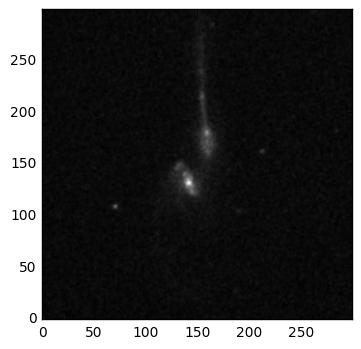

In [29]:
import astropy.io.fits as fits
hdu_list=fits.open(table.array['URL'][4])
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower')

<div class="alert alert-block alert-danger">
Need a note on why these look like they have different noise properties?<br><br>
And why does it so frequently time out?
</div>

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [16]:
params['survey']='sdssg'
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)

In [17]:
vot=votable.parse( io.StringIO( r.text) )
table = vot.get_first_table()
#fitslink=table.array['URL'][0]
#print fitslink
display(Image(url=table.array['URL'][1]))

<a id="example4"></a>
# Example 4:  HEASARC spectra retrieval
In addition to images, there are some spectra that can be retrieved from the HEASARC via the VO's Simple Spectral Access (SSA) Protocol. 

## 4.1 To see a list of available catalogs:
Currently, HEASARC has four catalogs that allow access to spectra through SSA.  

In [18]:
tap_params["query"]="""
    select distinct a.value,b.value
       from metainfo a, metainfo b
       where
        a.type='ssalink' and a.relation='table' and
        b.type='table' and b.relation='description' and
        a.value=b.name
    order by a.value
    """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<Table masked=True length=4>
  value               value_2            
  object               object            
---------- ------------------------------
chanmaster           Chandra Observations
    intbsc INTEGRAL Bright Source Catalog
swiftbalog       Swift BAT Instrument Log
swiftxrlog       Swift XRT Instrument Log

<div class="alert alert-block alert-danger">
This would be useful as a function, e.g.,<br>
astroquery.heasarc.list_ssa_services()
</div>

## 4.2 We can then search for the available Chandra spectra in a given region:

In [30]:
params = {'table': 'chanmaster',"POS":"187.27,2.05","SIZE":".01", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
spec_vot=votable.parse(io.StringIO(r.text))
spec_table = spec_vot.get_first_table()

In [31]:
for f in spec_table.fields:
        print f.ID

obsid
status
name
ra
dec
time
detector
grating
exposure
type
pi
public_date
SSA_datalength
SSA_datamodel
SSA_title
SSA_instrument
SSA_publisher
SSA_tmid
SSA_stop_time
SSA_start_time
SSA_duration
SSA_bandpass
SSA_wavelength_max
SSA_wavelength_min
SSA_bandwidth
SSA_ra
SSA_dec
SSA_coord_obs
SSA_fov
SSA_reference
SSA_format


In [32]:
print spec_table.array[0:3]['SSA_reference']

[ 'https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao08/cat7/7364/primary/acisf07364N004_pha2.fits.gz'
 'https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao08/cat7/7365/primary/acisf07365N002_pha2.fits.gz'
 'https://heasarc.gsfc.nasa.gov/FTP/chandra/data/cal/ao01/cat7/459/primary/acisf00459N004_pha2.fits.gz']


## 4.3  Download a spectrum and plot it:


ColDefs(
    name = 'SPEC_NUM'; format = '1I'; null = 0
    name = 'TG_M'; format = '1I'; null = 99
    name = 'TG_PART'; format = '1I'
    name = 'TG_SRCID'; format = '1I'; null = 0
    name = 'X'; format = '1E'; unit = 'pixel'
    name = 'Y'; format = '1E'; unit = 'pixel'
    name = 'CHANNEL'; format = '8192I'; null = 0
    name = 'COUNTS'; format = '8192I'; unit = 'count'; null = -1
    name = 'STAT_ERR'; format = '8192E'; unit = 'count'
    name = 'BACKGROUND_UP'; format = '8192I'; unit = 'count'; null = -1
    name = 'BACKGROUND_DOWN'; format = '8192I'; unit = 'count'; null = -1
    name = 'BIN_LO'; format = '8192D'; unit = 'angstrom'
    name = 'BIN_HI'; format = '8192D'; unit = 'angstrom'
)


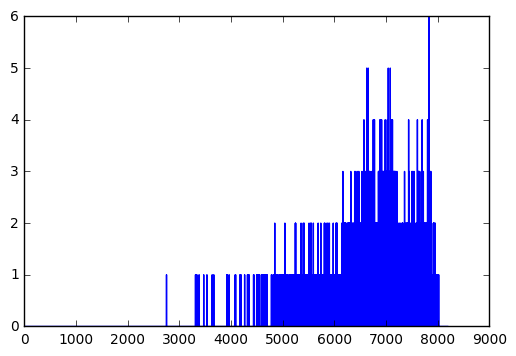

In [33]:
from astropy.table import Table
hdu_list=fits.open(spec_table.array[0]['SSA_reference'])
#hdu_list.info()
print hdu_list[1].columns
table = Table(hdu_list[1].data)
pha = plt.plot( table['CHANNEL'][8],table['COUNTS'][8])

<div class="alert alert-block alert-danger">
Better way to plot this?</div>

<a id="example5"></a>
# Example 5:  Search a cone
The __[Simple Cone Search (SCS) protocol](http://www.ivoa.net/documents/latest/ConeSearch.html)__ is used to search a given table with a given position and radius, getting again a VOTable XML result.  

## 5.1 Find SCS services for HEASARC
As above, first we use the TAP to find out what catalogs are available from HEASARC for cone searches:


In [34]:
tap_params["query"]="""
    select a.name,b.value
      from metainfo a, metainfo b
      where
         a.type='table' and b.type='table' and
         a.relation='defaultSearchRadius' and
         b.relation='description' and
         a.name=b.name
      order by name    
      """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<Table masked=True length=910>
   name                        value                     
  object                       object                    
---------- ----------------------------------------------
        a1                 HEAO 1 A1 X-Ray Source Catalog
   a1point                          HEAO 1 A1 Lightcurves
 a2lcpoint                  HEAO 1 A2 Pointed Lightcurves
  a2lcscan                  HEAO 1 A2 Scanned Lightcurves
     a2led                          HEAO 1 A2 LED Catalog
     a2pic                   HEAO 1 A2 Piccinotti Catalog
   a2point                     HEAO 1 A2 Pointing Catalog
a2specback                   HEAO 1 A2 Spectra Background
 a2spectra                              HEAO 1 A2 Spectra
        a3                      HEAO 1 A3 MC LASS Catalog
       ...                                            ...
xteasmlong XTE All-Sky Monitor Long-Term Observed Sources
 xteassagn            XTE All-Sky Slew Survey AGN Catalog
 xteasscat                XTE All-Sky Sle

## 5.2 Then perform a cone search on the catalog of interest:
In the case of a cone search, the standard specifies "RA", "DEC", "SR", etc. but not how the specific catalog/table is specified.  The normal way one does this is to query the registry and find the URL specific to the catalog, which in this case ends with something like "?table=zcat&".  For this example, we'll simply add that to the requests parameters.  

In [36]:
params = {'table': 'zcat', 'RA': '9.90704', 'DEC':'8.96507', 'SR':'0.5'}
r = requests.get('https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl', params=params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<Table masked=True length=5>
   name       ra      dec     bmag  ... redshift class Search_Offset
             deg      deg           ...                             
  object   float64  float64 float32 ... float64  int32    float64   
---------- -------- ------- ------- ... -------- ----- -------------
 0037+0829  9.97192 8.76280      -- ...       --  9999       12.7313
00357+0831  9.57248 8.79145   17.00 ...       --  9999       22.4024
 0037+0836 10.08085 8.88882   16.50 ...       --  9999       11.2726
00370+0841  9.90662 8.96785   15.20 ...       --  6200        0.1685
00371+0843  9.92291 9.00089   15.00 ...       --  6200        2.3460

<a id="pvo"></a>
# Example 6:  Using the TAP for cross-correlation with an uploaded table

First create a table following the example in http://docs.astropy.org/en/stable/io/votable/:

In [42]:
##  Create a table with only two objects in it:
from astropy.io.votable.tree import VOTableFile, Resource, Table, Field

# Create a new VOTable file...
vot = VOTableFile()

# ...with one resource...
resource = Resource()
vot.resources.append(resource)

# ... with one table
mytable = Table(vot)
resource.tables.append(mytable)

# Define some fields
mytable.fields.extend([
        Field(vot, name="name",  datatype="char", arraysize="*"),
        Field(vot, name="ra",  datatype="double", arraysize="*"),
        Field(vot, name="dec", datatype="double", arraysize="*")])

# Now, use those field definitions to create the numpy record arrays, with
# the given number of rows
mytable.create_arrays(2)

# Now table.array can be filled with data
#  Two of the sources that matched above.
mytable.array[0] = ("12406+3040S",190.76628151, 30.385443429999999)
mytable.array[1] = ("A1257+3514",194.88469527999999,34.980354130000002)

# Now write the whole thing to a file.
# Note, we have to use the top-level votable file object
vot.to_xml("new_votable.xml")
mytable

<Table masked=True length=2>
    name         ra          dec    
   object      object       object  
----------- ------------ -----------
12406+3040S 190.76628151 30.38544343
 A1257+3514 194.88469528 34.98035413

<div class="alert alert-block alert-danger">
Why does that take so many lines and can it be simplified?</div>

We can then hand this table to a service and reference it in the ADQL.  

In this simple example, we first run the above query that found all the soruces in a given region with a given magnitude from the zcat.   

In [62]:
tap_params["query"]="""SELECT * FROM zcat as cat where cat.RA > 190. and cat.RA < 195 and cat.Dec > 30. and cat.Dec < 35 and cat.Bmag > 14.9"""
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params )
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<Table masked=True length=36>
__row     name    ...      __y_ra_dec           __z_ra_dec    
int32    object   ...       float64              float64      
----- ----------- ... -------------------- -------------------
44471  12388+3024 ... -0.85095294249416598 0.50190152660460496
44638 12406+3040S ... -0.84745741923795403 0.50581461750528101
44639 12406+3040N ... -0.84745741923795403 0.50581461750528101
44753  12523+3048 ... -0.83694373047007298 0.50797744806688205
44876  12543+3059 ... -0.83355555309067597 0.51073960747015601
44890      N4676A ... -0.84218280700419401 0.51102705631205503
44900  12472+3101 ... -0.83938774592399301 0.51121065877984095
44968  12480+3107 ... -0.83786663998140898 0.51271298684336897
45008  12466+3111 ... -0.83841224172975004 0.51370627736774599
45120  12514+3122 ... -0.83265960327019894    0.51663830598047
  ...         ... ...                  ...                 ...
46935       N4737 ... -0.80729422207647505 0.56128689176181301
46989   1244+3433 ... -0.

The two sources in our custom-made table are simply two of these.  

We can then do a trivial cross-correlation between the zcat contents and our own table, in this case simply asking for the subset of sources above that happen to have names in our table:

In [79]:
print tap_params

{'lang': 'ADQL', 'query': 'SELECT * FROM zcat as cat where cat.RA > 190. and cat.RA < 195 and cat.Dec > 30. and cat.Dec < 35 and cat.Bmag > 14.9', 'request': 'doQuery', 'mytable': <open file 'new_votable.xml', mode 'rb' at 0x113f3bd20>, 'file': ('mytable', <open file 'new_votable.xml', mode 'rb' at 0x113f3bb70>)}


In [88]:
## These are defined in the TAP standard:
cc_params={'lang': 'ADQL', 'request': 'doQuery','upload':'mytable,param:tab1'}
## This is your ADQL query, where "mytable" here has to match what you specified in the upload parameter 
cc_params["query"]="""SELECT * FROM zcat cat, tap_upload.mytable mt where cat.RA > 190. and cat.RA < 195 
    and cat.Dec > 30. and cat.Dec < 35 and cat.Bmag > 14.9 and cat.name = mt.name"""
## The name you give here (tab1) matches what's in the cc_params
files={'tab1':open('new_votable.xml', 'rb')}
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,stream=True,files=files)
#r.text
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<Table masked=True length=2>
__row     name            ra         ...        ra_2              dec_2       
int32    object        float64       ...       object             object      
----- ----------- ------------------ ... ------------------ ------------------
44638 12406+3040S       190.76628151 ...       190.76628151 30.385443429999999
47331  A1257+3514 194.88469527999999 ... 194.88469527999999 34.980354130000002

For a mores sophisticated example, we can use the ADQL function *contains* to find sources in rosmaster catalog that are within a specified distance from each source in the uploaded table.  